## Component 3. Topic Evolution in NIPS dataset

### Dynamic topic model(DTM) componet

Import the libraries.

In [169]:
%matplotlib inline
import pandas as pd
import numpy as np

from gensim import models, corpora
from gensim.models.wrappers.dtmmodel import DtmModel
from gensim.corpora import Dictionary, MmCorpus
from gensim.models import Phrases

from nltk import RegexpTokenizer
from nltk.corpus import stopwords, inaugural
from nltk.stem import PorterStemmer, WordNetLemmatizer

import warnings
warnings.filterwarnings('ignore')

import pyLDAvis
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
pyLDAvis.enable_notebook()

Load the paper texts as documents and record the time sequence of each year.

In [31]:
def load_doc(input):
    df = pd.read_csv(input)
    df.columns.get_values()
    documents = df['paper_text']
    documents.tolist()
    paper_year=df.groupby(['year']).size()
    time_seq = paper_year.tolist()
    return documents, time_seq

Natural Language Toolkit (NLTK) is applied to preprocess the documents. The process including:
    - Tokenise string.
    - Remove stop words
    - Remove non-letters
    - Convert letters to lower-case 
    - Remove words lee then three letters
    - Add bigrams
    - Filter out words occur less then 20 times and more then 50% of documents

In [19]:
def process_corpus(corpus): 
    wnl = WordNetLemmatizer()
    stops = stopwords.words('english')
    stops.extend(['figure','fig','pp','number','zero','one','two','three','four','five','six','seven','eight','nine','ten','across','among','beside','however','let','within','et','al'])
    processed_corpus = []
    tokenizer = RegexpTokenizer(r'[A-Za-z]+') # remove non-letters
    print('Cleaning the documents...')
    for document in corpus:
        document = ' '.join(tokenizer.tokenize(document)) # tokenise string
        document = [word for word in document.lower().split() if word not in stops] # convert to lower-case
        document = [word for word in document if len(word) > 3]  # remove all single-letter words
        document = [wnl.lemmatize(word) for word in document]  # lemmatize token
        processed_corpus.append(document)
    documents = processed_corpus
    # Add bigrams and trigrams to docs (only ones that appear 20 times or more).
    bigram = Phrases(documents, min_count=20)
    for idx in range(len(documents)):
        for token in bigram[documents[idx]]:
            if '_' in token:
                # Token is a bigram, add to document.
                documents[idx].append(token)
                
    print('Building dictionary...')
    dictionary = Dictionary(documents)
    # Filter out words that occur too frequently or too rarely.
    max_freq = 0.5
    min_wordcount = 20
    dictionary.filter_extremes(no_below=min_wordcount, no_above=max_freq)

    print('Building corpus...')
    corpus = [dictionary.doc2bow(doc) for doc in documents]
    return dictionary, corpus

Building dictionary...
Building corpus...


In [34]:
input = '/Users/lillian/Documents/workspace/ir/data/papers.csv'
docs, time_seq = load_doc(input)
#dictionary, corpus = process_corpus(docs)
MmCorpus.serialize('papers.mm', corpus)
dictionary.save('papers.dict')

Run DTM model with 10 topics.

In [37]:
# Load corpora and Dictionary
corpus = corpora.MmCorpus('papers.mm')
dictionary = Dictionary.load('papers.dict')
# Build DTM model
dtm_path = "/Users/lillian/Documents/workspace/dtm-master/dtm/dtm-main"
model = DtmModel(dtm_path, corpus, time_seq, num_topics=10,
                 id2word=dictionary, initialize_lda=True)
model.save('dtm_topic10_1016')

KeyboardInterrupt: 

In [143]:
def export_topics_csv(dtm_model, model_name, topics_n):
    df_topics = []
    topicid = topics_n
    num_words= 40
    for topicid in range(1, topicid+1):
        for time in range(0, 29):
            if time == 0:
                year1 = dtm_model.show_topic(topicid=topicid-1, time=time, topn=num_words)
                year2 = dtm_model.show_topic(topicid=topicid-1, time=time+1, topn=num_words)
                df1 = pd.DataFrame(year1,columns=[str(1987+time), 'Topic'+str(topicid)])
                df2 = pd.DataFrame(year2,columns=[str(1987+time+1), 'Topic'+str(topicid)])
                df_topics = df1.merge(df2, on='Topic'+str(topicid))   
            else:
                year3 = dtm_model.show_topic(topicid=topicid-1, time=time+1, topn=num_words)
                df3 = pd.DataFrame(year3,columns=[str(1987+time+1), 'Topic'+str(topicid)])
                df_topics = df_topics.merge(df3, on='Topic'+str(topicid))   

        df_topics.to_csv(model_name+'_topic'+str(topicid)+'.csv')
        del df_topics 

In [144]:
def export_dist_csv(dtm_model, model_name, topics_n):
    doc_number = 6560
    topics = topics_n
    distributions = []
    for j in range(0, doc_number):
        for i in range(0, topics):
            distribution = dtm_model.gamma_[j, i]
            distributions.append(distribution) 

    df_distribution = pd.DataFrame(distributions)
    df_distribution.to_csv(model_name+'_distribution.csv')

Export the model and data.

In [148]:
# Export the output data to csv files
topics_n = 10
model_name = 'dtm_10_1016'
dtm_model = DtmModel.load('dtm_topic10_1016')
export_topics_csv(dtm_model, model_name, topics_n)
export_dist_csv(dtm_model, model_name, topics_n)

In [162]:
def load_tableau10():
    # Scale the RGB values for "Tableau 10". 
    tableau10 = [(31, 119, 180), (255, 127, 14), (44, 160, 44),
                 (214, 39, 40), (148, 103, 189), (140, 86, 75),    
                 (227, 119, 194), (127, 127, 127), (188, 189, 34), (23, 190, 207)]  
    for i in range(len(tableau10)):    
        r, g, b = tableau10[i]    
        tableau10[i] = (r / 255., g / 255., b / 255.)   
    return tableau10

def load_tableau20():
    # Scale the RGB values for "Tableau 20". 
    tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
                 (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
                 (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
                 (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
                 (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    

    # Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
    for i in range(len(tableau20)):    
        r, g, b = tableau20[i]    
        tableau20[i] = (r / 255., g / 255., b / 255.)     
    return tableau20
    
def visualize_topic_evolution(topic_n, path):
    topics = topic_n
    for topic in range (1,topics+1):
        input = path+'topic'+str(topic)+'.csv'
        df = pd.read_csv(input)

        words = df['Topic'+str(topic)]
        probs = df.drop(['Topic'+str(topic)], axis=1)
        probs = probs[0:10]
        probs = probs.T
        probs = probs[1:31]
        ax = probs.plot(title='Topic'+str(topic), color=tableau10)
        ax.legend(words[0:10], loc='center left', bbox_to_anchor=(1, 0.5))
        plt.show()

In [166]:
def visualize_distribution_evolution(topic_n, path):
    topics = topic_n
    years = 30
    tt=[]
    tmp_distribution= []
    topics_list = ["Topic"+str(i) for i in range(1, topics+1)]
    input = path+'distribution.csv'
    df = pd.read_csv(input, sep=',')

    tmp = df['0'].values.reshape(6560, topics) 
    dis = pd.DataFrame(tmp)
    for year in range(0,years):
        for i in range(0,topics):
            if year == 0:
                tmp_distribution.append(sum(dis[i].iloc[0:time_seq[0]])/time_seq[0])
            else:
                tmp_distribution.append( sum(dis[i].iloc[time_seq[year-1]:time_seq[year-1]+time_seq[year]]) / time_seq[year] )

    year_distribution = pd.DataFrame(np.array(tmp_distribution).reshape(years, topics), 
                                     index=range(1987,1987+years), columns=topics_list)

    #year_distribution.plot.bar(stacked=True , color=tableau20)
    ax = year_distribution.plot(title='Topics distribution', color=tableau10)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

Visualize top-30 words in each topic.

In [170]:
# Visualize top-30 words in each topic
dtm_model = DtmModel.load('dtm_topic10_1016')
time=1
doc_topic, topic_term, doc_lengths, term_frequency, vocab = dtm_model.dtm_vis(time=time, corpus=corpus)
vis_wrapper = pyLDAvis.prepare(topic_term_dists=topic_term, doc_topic_dists=doc_topic, doc_lengths=doc_lengths, vocab=vocab, term_frequency=term_frequency)
pyLDAvis.display(vis_wrapper)

Visualize topic evolution and topics distribution.

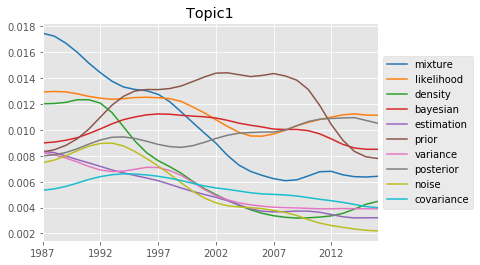

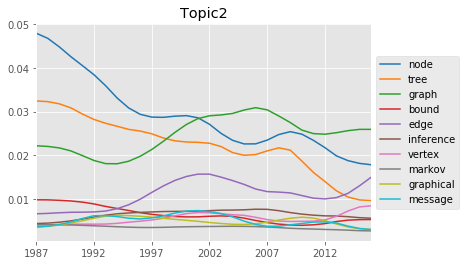

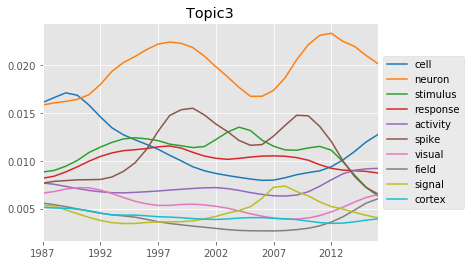

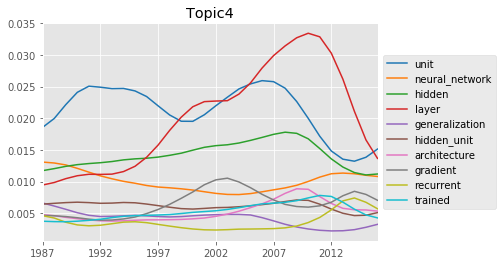

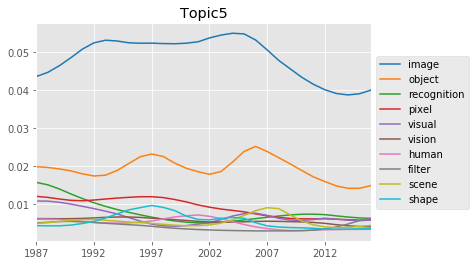

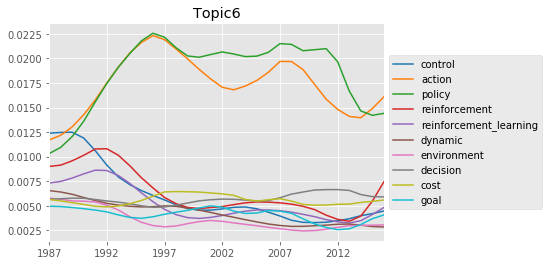

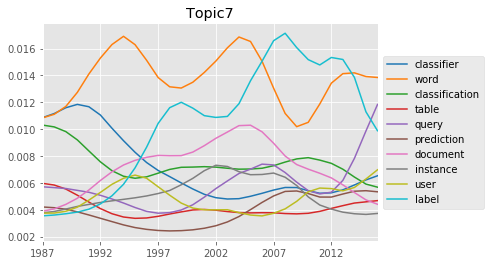

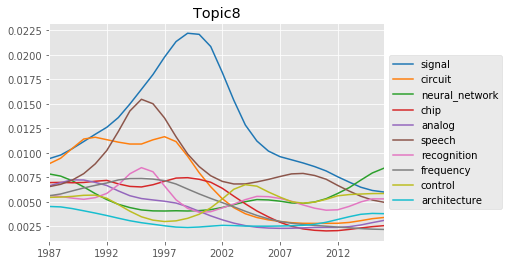

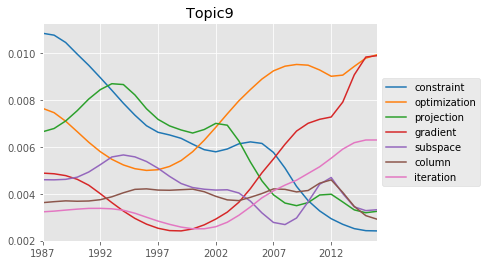

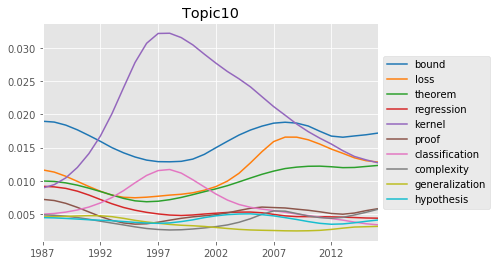

In [164]:
# Visualize topic evolution
topics_n = 10
path = '/Users/lillian/Documents/workspace/ir/dtm_10_1016_'
tableau10=load_tableau10()

visualize_topic_evolution(topics_n, path)

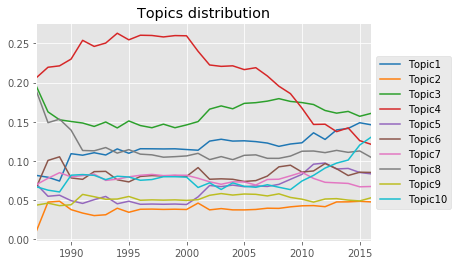

In [167]:
# visualize topics distribution
tableau10=load_tableau10()
visualize_distribution_evolution(topics_n, path)